## Work on GEFS

In [2]:
from herbie import Herbie, FastHerbie
import pandas as pd
import pvlib
model_cs = 'haurwitz'

Getting it every 6 hours provides 6-hr averages. Quick demo:

In [3]:
H = Herbie(
    '2021-04-09 06:00',
    model='gefs',
    product="atmos.5",
    member="p01", fxx=3
)
H.inventory("DSWRF")

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,?,search_this
77,78,14848370,14920417.0,14848370-14920417,2021-04-09 06:00:00,2021-04-09 09:00:00,DSWRF,surface,0-3 hour ave fcst,ENS=+1,:DSWRF:surface:0-3 hour ave fcst:ENS=+1


In [4]:
H = Herbie(
    '2021-04-09 06:00',
    model='gefs',
    product="atmos.5",
    member="p01", fxx=6
)
H.inventory("DSWRF")

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,?,search_this
77,78,14488024,14565241.0,14488024-14565241,2021-04-09 06:00:00,2021-04-09 12:00:00,DSWRF,surface,0-6 hour ave fcst,ENS=+1,:DSWRF:surface:0-6 hour ave fcst:ENS=+1


In [5]:
H = Herbie(
    '2021-04-09 06:00',
    model='gefs',
    product="atmos.5",
    member="p01", fxx=9
)
H.inventory("DSWRF")

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,?,search_this
77,78,14651653,14721369.0,14651653-14721369,2021-04-09 06:00:00,2021-04-09 15:00:00,DSWRF,surface,6-9 hour ave fcst,ENS=+1,:DSWRF:surface:6-9 hour ave fcst:ENS=+1


In [6]:
H = Herbie(
    '2021-04-09 06:00',
    model='gefs',
    product="atmos.5",
    member="p01", fxx=12
)
H.inventory("DSWRF")

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,?,search_this
77,78,14654062,14786504.0,14654062-14786504,2021-04-09 06:00:00,2021-04-09 18:00:00,DSWRF,surface,6-12 hour ave fcst,ENS=+1,:DSWRF:surface:6-12 hour ave fcst:ENS=+1


First, we could get 2m temp from GEFS mean or from GFS. With a single variable, we can use `FastHerbie`. 

(Note: Hopefully we can use `FastHerbie` with multiple levels/parameters once this PR is merged https://github.com/blaylockbk/Herbie/pull/417 and/or this gets addressed https://github.com/blaylockbk/Herbie/issues/146)

We can then use `FastHerbie` to get `DSWRF` from all 30 members at 6h intervals, and use similar processes to `get_solar_forecast` to use clear sky to interpolate to hourly. 

In [7]:
## Sample temp data:
# inputs:
date = '2024-06-05 06:00'
latitude = [33.5, 32]
longitude = [-88.5, -89]
num_members = 2
length_hours = 24
lead_time_hours = 24

# mock function
#------------------------
fxx = range (6, length_hours + lead_time_hours + 1, 6)
# search_str = 'DSWRF|:TMP:2 m above|[UV]GRD:10 m above'
search_str = ':TMP:2 m above'
ds = FastHerbie(DATES=[date], model='gefs' ,product='atmos.5', member = 'mean', fxx=fxx).xarray(search_str)

# merge - override avoids hight conflict between 2m temp and 10m wind
# ds = xr.merge(ds, compat='override')
# calculate wind speed from u and v components
# ds = ds.herbie.with_wind('speed')

ds2 = ds.herbie.pick_points(pd.DataFrame({
                    "latitude": [latitude[0]],
                    "longitude": [longitude[0]],
                    }))

df_temp = ds2.to_dataframe()
df_temp

,,t2m,time,heightAboveGround,latitude,longitude,valid_time,gribfile_projection,point_grid_distance,point_latitude,point_longitude
step,point,,,,,,,,,,
0 days 06:00:00,0,294.799988,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-05 12:00:00,None,1.301233e-12,33.5,-88.5
0 days 12:00:00,0,304.899994,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-05 18:00:00,None,1.301233e-12,33.5,-88.5
0 days 18:00:00,0,298.200012,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-06 00:00:00,None,1.301233e-12,33.5,-88.5
1 days 00:00:00,0,294.700012,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-06 06:00:00,None,1.301233e-12,33.5,-88.5
1 days 06:00:00,0,293.799988,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-06 12:00:00,None,1.301233e-12,33.5,-88.5
1 days 12:00:00,0,303.399994,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-06 18:00:00,None,1.301233e-12,33.5,-88.5
1 days 18:00:00,0,301.000000,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-07 00:00:00,None,1.301233e-12,33.5,-88.5
2 days 00:00:00,0,294.700012,2024-06-05 06:00:00,2.0,33.5,271.5,2024-06-07 06:00:00,None,1.301233e-12,33.5,-88.5


Sample getting ghi (DSWRF) from many GEFS members for many sites:

In [ ]:
# inputs:
date = '2024-06-05 06:00'
latitude = [33.5, 32, 33]
longitude = [-88.5, -89, -91]
num_members = 30
length_hours = 72 # needs to be multiple of 6
lead_time_hours = 18 # needs to be a multiple of 6

# mock function
#------------------------
num_sites = len(latitude)
fxx = range (6, length_hours + lead_time_hours + 1, 6)
member_list = [f"p{x:02d}" for x in range(1, num_members+1)]
dfs = []
for member in member_list:
    ds = FastHerbie(DATES=[date], model='gefs' ,product='atmos.5', member = member, fxx=fxx).xarray('DSWRF')
    # use pick_points for single point or list of points
    ds2 = ds.herbie.pick_points(pd.DataFrame({
                    "latitude": latitude,
                    "longitude": longitude,
                    }))

    # convert to dataframe
    df_temp = ds2.to_dataframe().reset_index().set_index('valid_time')[['point','dswrf']]
    # add timezone
    df_temp = df_temp.tz_localize('UTC', level='valid_time')

    # df_temp['member'] = member

    # dfs = {}  # empty list of dataframes
    for j in range(num_sites):
        df = df_temp[df_temp['point'] == j]
        # df = df.droplevel('point')

        # for gfs ghi: we have to "unmix" the rolling average irradiance
        # that resets every 6 hours
        mixed = df[['dswrf']].copy()
        mixed['hour'] = mixed.index.hour
        mixed['hour'] = mixed.index.hour
        mixed['hour_of_mixed_period'] = ((mixed['hour'] - 1) % 6) + 1
        mixed['sdswrf_prev'] = mixed['dswrf'].shift(
            periods=1,
            fill_value=0
            )
        mixed['int_len'] = mixed.index.diff().total_seconds().values / 3600

        # set the first interval length:
        # if lead_time_hours >= 120:
        #     mixed.loc[mixed.index[0], 'int_len'] = 1
        # else:
        #     mixed.loc[mixed.index[0], 'int_len'] = 3
        mixed.loc[mixed.index[0], 'int_len'] = 6
        unmixed = ((mixed['hour_of_mixed_period'] * mixed['dswrf']
                    - (mixed['hour_of_mixed_period'] - mixed['int_len'])
                    * mixed['sdswrf_prev']) / mixed['int_len'])
        df['ghi'] = unmixed

        # make 5min interval clear sky data covering our time range
        times = pd.date_range(
            start=df.index[0],
            end=df.index[-1],
            freq='5min',
            tz='UTC')

        loc = pvlib.location.Location(
            latitude=latitude[j],
            longitude=longitude[j],
            tz=times.tz
            )
        cs = loc.get_clearsky(times, model=model_cs)

        # calculate average CS ghi over the intervals from the forecast
        # based on list comprehension example in
        # https://stackoverflow.com/a/55724134/27574852
        ghi = cs['ghi']
        dates = df.index
        ghi_clear = [
            ghi.loc[(ghi.index > dates[i]) & (ghi.index <= dates[i+1])].mean()
            for i in range(len(dates) - 1)
            ]

        # write to df and calculate clear sky index of ghi
        df['ghi_clear'] = [np.nan] + ghi_clear
        df['ghi_csi'] = df['ghi'] / df['ghi_clear']

        # avoid divide by zero issues
        df.loc[df['ghi'] == 0, 'ghi_csi'] = 0

        # 60min version of data, centered at bottom of the hour
        # 1min interpolation, then 60min mean
        df_60min = (
            df[['ghi']]
            .resample('1min')
            .interpolate()
            .resample('60min').mean()
        )
        # make timestamps center-labeled for instantaneous pvlib modeling later
        df_60min.index = df_60min.index + pd.Timedelta('30min')
        # drop last row, since we don't have data for the last full hour (just
        # an instantaneous end point)
        df_60min = df_60min.iloc[:-1]
        # "backfill" ghi csi
        # merge based on nearest index from 60min version looking forward in
        # 3hr version
        df_60min = pd.merge_asof(
            left=df_60min,
            right=df.ghi_csi,
            on='valid_time',
            direction='forward'
        ).set_index('valid_time')

        # make 60min interval clear sky, centered at bottom of the hour
        times = pd.date_range(
            start=df.index[0]+pd.Timedelta('30m'),
            end=df.index[-1]-pd.Timedelta('30m'),
            freq='60min',
            tz='UTC')
        cs = loc.get_clearsky(times, model=model_cs)

        # calculate ghi from clear sky and backfilled forecasted clear sky
        # index
        df_60min['ghi'] = cs['ghi'] * df_60min['ghi_csi']

        # dni and dhi using pvlib erbs. could also DIRINT or erbs-driesse
        sp = loc.get_solarposition(times)
        out_erbs = pvlib.irradiance.erbs(
            df_60min.ghi,
            sp.zenith,
            df_60min.index,
        )
        df_60min['dni'] = out_erbs.dni
        df_60min['dhi'] = out_erbs.dhi

        # add clearsky ghi
        df_60min['ghi_clear'] = df_60min['ghi'] / df_60min['ghi_csi']

        # add member and point
        df_60min['member'] = member
        df_60min['point'] = j

        # dfs[j] = df_60min
        dfs.append(df_60min)

dfs = pd.concat(dfs)

In [ ]:
dfs

,ghi,ghi_csi,dni,dhi,ghi_clear,member,point
valid_time,,,,,,,
2024-06-05 12:30:00+00:00,281.003157,0.901189,517.980935,106.252652,311.813824,p01,0
2024-06-05 13:30:00+00:00,469.264851,0.901189,621.731628,139.944627,520.717521,p01,0
2024-06-05 14:30:00+00:00,637.238703,0.901189,667.760479,169.559929,707.108911,p01,0
2024-06-05 15:30:00+00:00,772.740614,0.901189,691.223972,193.631021,857.467965,p01,0
2024-06-05 16:30:00+00:00,866.304869,0.901189,703.331913,210.360168,961.291098,p01,0
...,...,...,...,...,...,...,...
2024-06-08 19:30:00+00:00,918.891879,0.958840,803.783132,171.432043,958.337030,p30,2
2024-06-08 20:30:00+00:00,815.679288,0.958840,792.712898,156.448059,850.693845,p30,2
2024-06-08 21:30:00+00:00,668.300064,0.958840,770.634437,135.706012,696.988093,p30,2


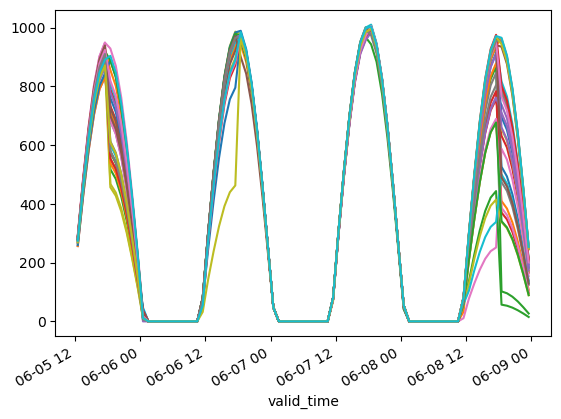

In [ ]:
member_list = dfs['member'].unique()
for member in member_list:
    dfs[(dfs['member'] == member) & (dfs['point'] == 0)]['ghi'].plot(label=member)